In [11]:
import numpy as np
import pandas as pd
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
from util import BruxKori, Kinetic, Optimal
import math

In [2]:
data_pd = pd.read_csv('kkm_data.csv', delimiter=";")
pc = data_pd.columns[6:]

data = {}
for i in range(data_pd.shape[0]):
    data[int(data_pd["Лабораторный №"][i])] = {"kpr": float(data_pd["Кпр, мД"][i]),
                                               "kp": float(data_pd["Кп, %"][i]),
                                               "kv": [float(i) for i in data_pd.loc[i][pc].tolist()]}
pc = np.array([float(i) for i in pc])

In [3]:
data_pd

,Месторождение,Скв.,Пласт,Лабораторный №,"Кпр, мД","Кп, %",0.001,0.016,0.027,0.047,0.081,0.139,0.238,0.406,0.7,1.2
0,Чудесное,1,VI-2,1,38.0,36.5,100,96.13,95.13,93.10,89.29,81.10,72.04,64.74,59.34,56.31
1,Чудесное,1,VI-2,2,16.8,35.8,100,96.28,95.40,94.50,92.40,88.74,79.58,71.16,65.42,62.01
2,Чудесное,1,VI-2,3,12.3,34.0,100,97.49,96.49,95.23,93.53,89.53,82.04,72.66,65.90,62.90
3,Чудесное,1,VI-2,4,51.0,36.8,100,94.43,93.40,91.48,85.23,75.49,66.59,60.40,56.40,54.30
4,Чудесное,1,VI-2,5,38.0,37.0,100,94.70,93.70,92.25,89.04,79.35,69.12,61.31,56.15,53.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,Чудесное,1,XXI,78,98.0,31.7,100,96.55,93.37,87.40,75.65,64.50,57.32,51.51,47.64,45.06
76,Чудесное,1,XXI,79,61.0,33.4,100,97.05,95.18,91.91,81.45,70.48,62.03,55.69,51.52,48.96
77,Чудесное,1,XXI,80,78.0,32.3,100,97.93,96.06,91.31,79.90,68.87,59.62,52.97,48.50,45.94
78,Чудесное,1,XXI,81,20.0,30.9,100,98.24,97.04,95.84,92.84,86.33,78.82,72.87,67.93,64.93


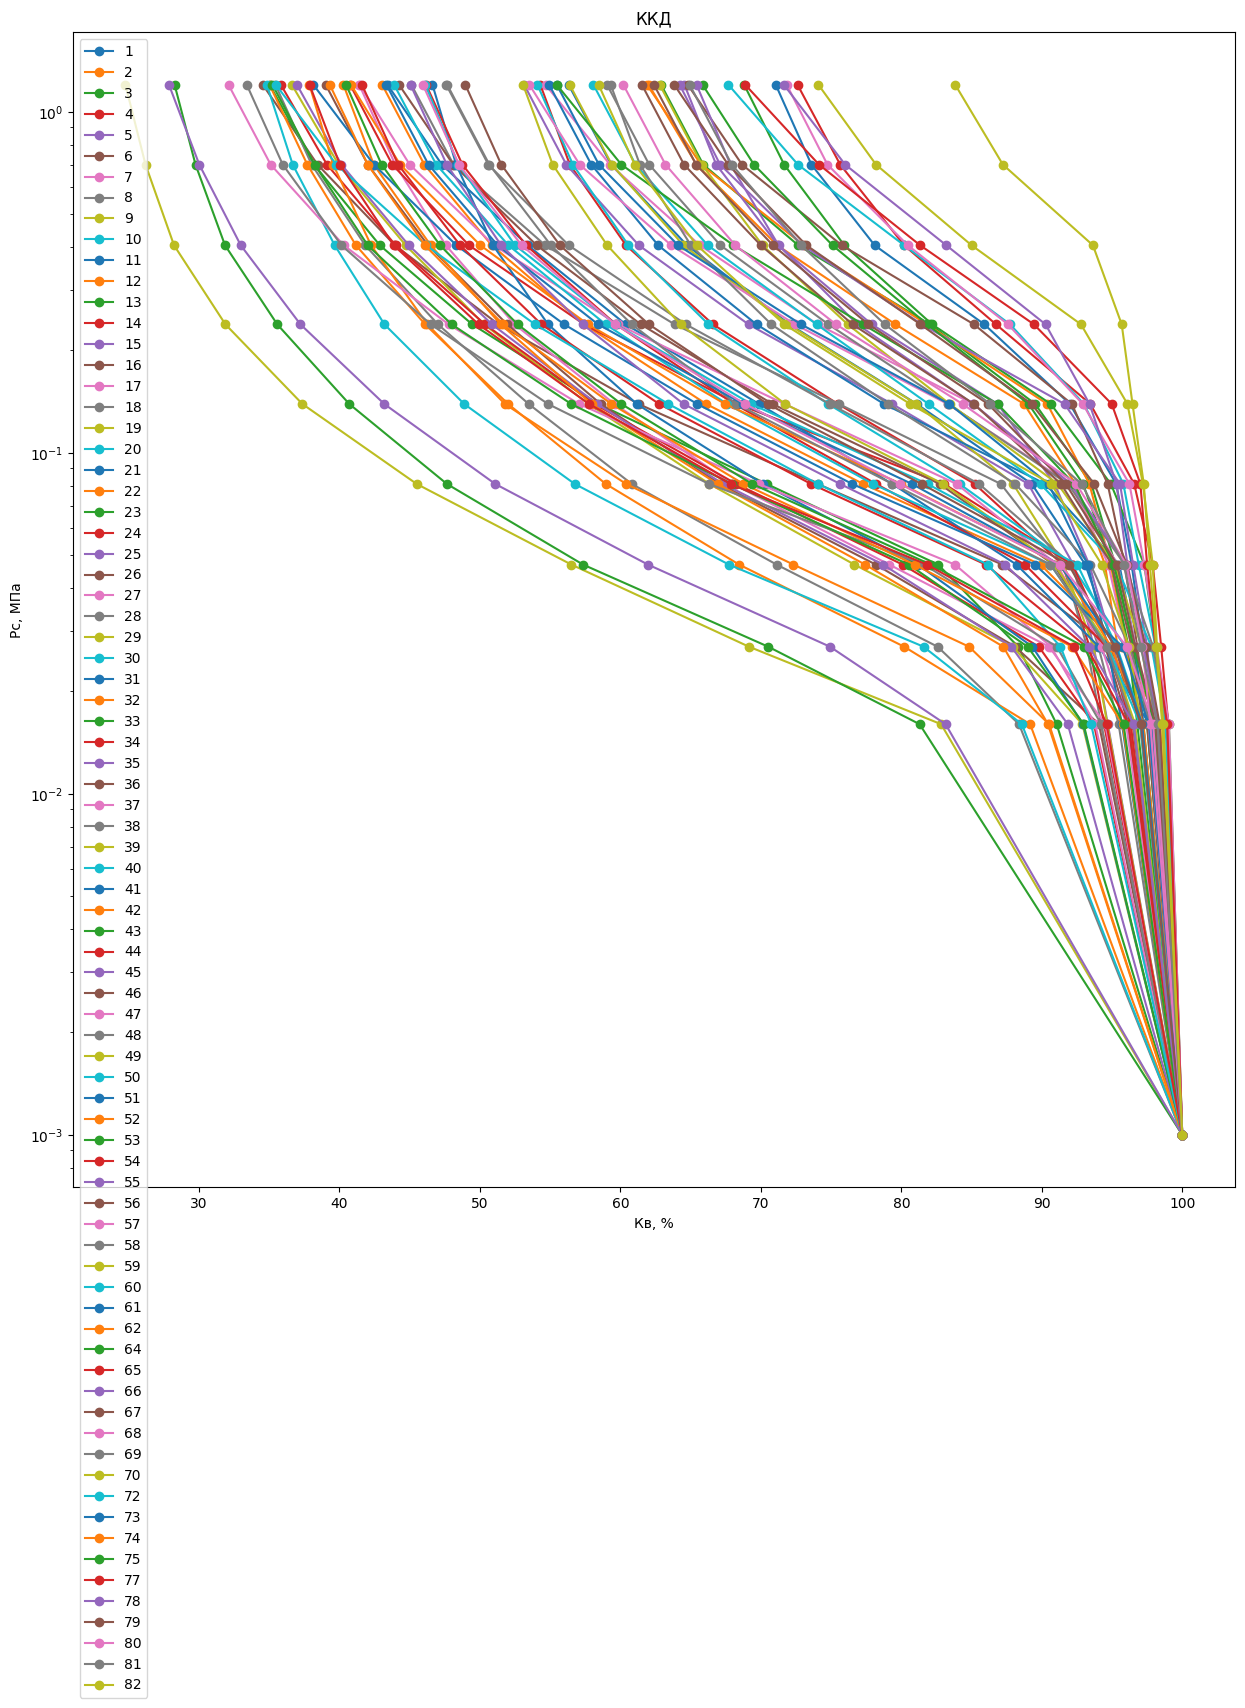

In [4]:
fig, ax = plt.subplots(figsize=(15,15))

for num in data.keys():
    ax.plot(data[num]["kv"], pc, marker="o", label = num)
ax.set_xlabel('Кв, %')
ax.set_ylabel('Pc, МПа')
ax.set_yscale('log')
ax.set_title("ККД")
ax.legend()


In [15]:
def plot_all_models(data, pc, model_name):
    """
    Function to iterate through all models, predict, and plot real and predicted curves.
    """
    num_models = len(data)
    num_cols = 4
    num_rows = math.ceil(num_models / num_cols)
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
    axes = axes.flatten()  # Flatten the axes array for easy iteration
    
    for idx, num in enumerate(data.keys()):
        mask = np.full(pc.shape, True)
        match model_name:
            case "BruxKori":   
                model = BruxKori(data[num]["kv"], pc)
            case "Kinetic":
                model = Kinetic(data[num]["kv"], pc)
                mask = (model.pc > model.pc_vh)
            case "Optimal":
                model = Optimal(data[num]["kv"], pc)
            case "Tomira":
                pass
            case "Trigonometric":
                pass
        
        predicted = model.predict()
        real = model.kv
        
        ax = axes[idx]
        ax.plot(real, pc, marker="o", linestyle="-", label="Real")
        ax.plot(predicted, pc[mask], marker="o", linestyle="--", label="Predicted")
        
        ax.set_xlabel("Kv, %")
        ax.set_ylabel("Pc, МПа")
        ax.set_yscale("log")
        ax.set_title(f"Model {num}")
        ax.hlines(y=model.pc_vh, xmin=30, xmax=100, label="pc_vh", colors="r")
        ax.legend()
    
    # Hide unused subplots
    for ax in axes[num_models:]:
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()

# Brux Kori

In [6]:
# plot_all_models(data, pc, model_name="BruxKori")

Определенно есть вылеты в автоматическом определении pc_vh, но лучше сделать у меня не получилось, да и модель как-то не очень выглядит...

# Kinetic

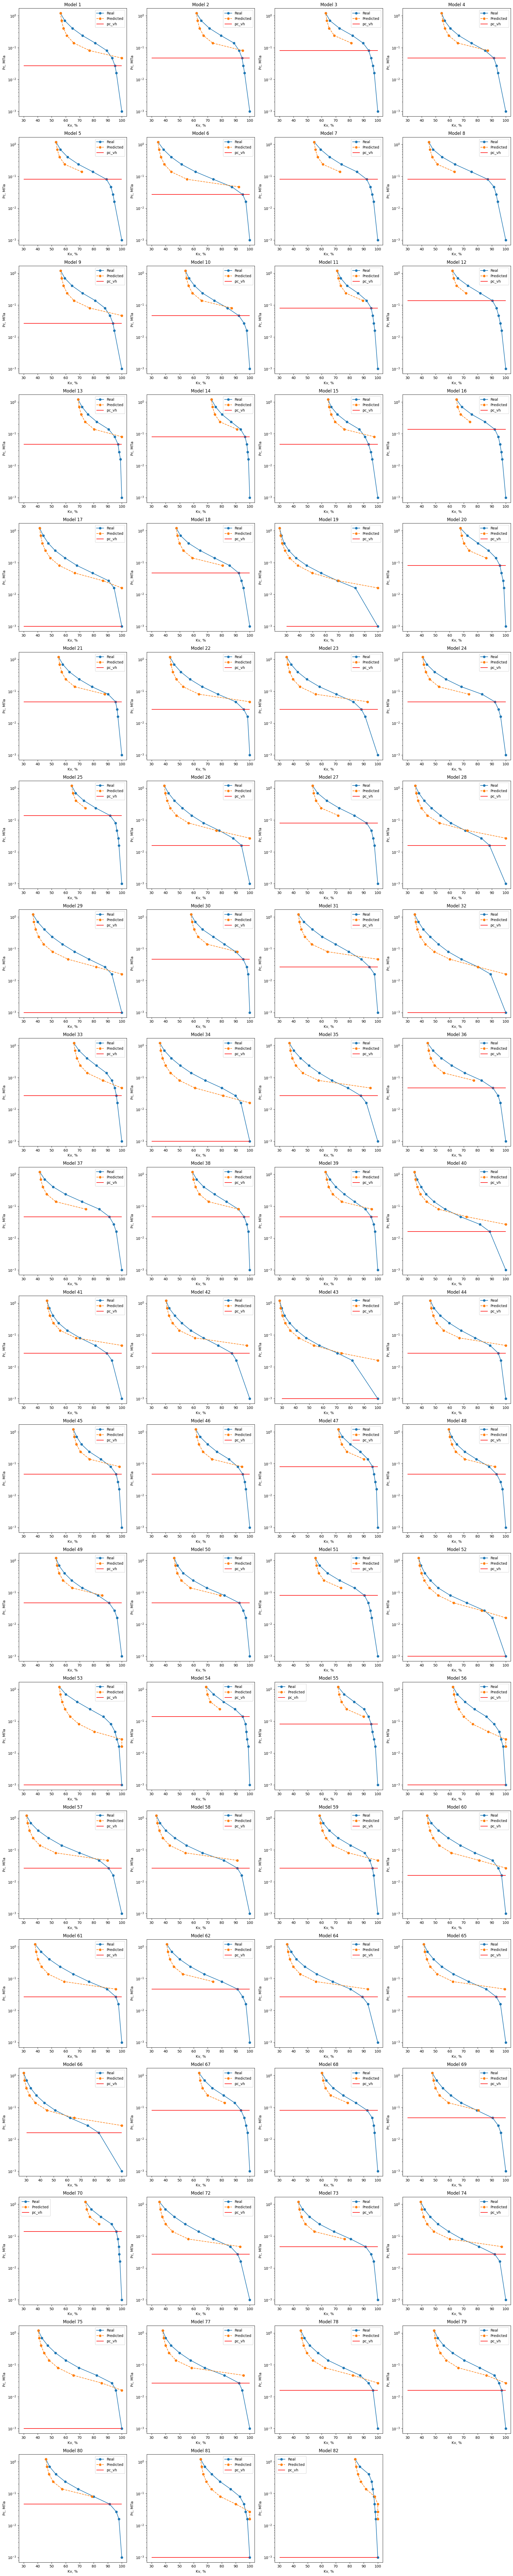

In [ ]:
# plot_all_models(data, pc, model_name="Kinetic")

# Optimal

c:\Users\artemiy\Documents\University\1 course\2 sem\PetroPhysics\Pertoleum-Geology-Projects\Artemiy_Fishchuk_examples\03 Capilarry curve modeling\util.py:91: RuntimeWarning: invalid value encountered in power
  alpha = (self.pc/a)**(1/b)


ValueError: x and y must have same first dimension, but have shapes (7,) and (10,)

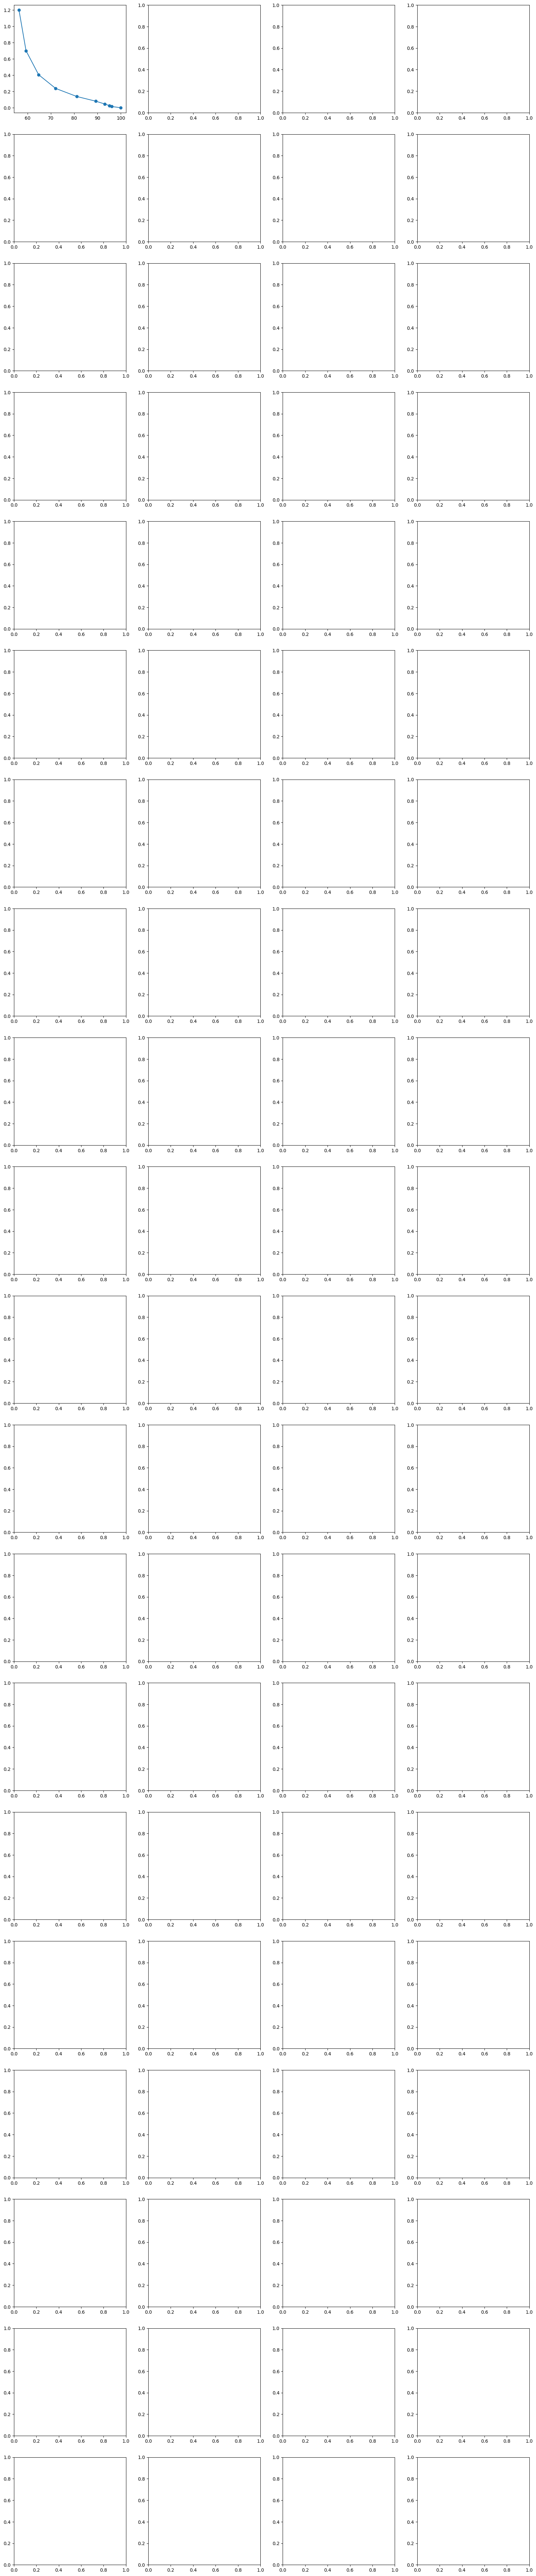

In [16]:
plot_all_models(data, pc, model_name="Optimal")